In [10]:
pip install mplfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import plotly.express as px
import numpy as np
import yfinance as yf
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
# File path
file_path = "datasets/TCS_stock_history.csv"

# Load existing data
if os.path.exists(file_path):
    tcs_stock_history_data = pd.read_csv(file_path, parse_dates=["Date"])
else:
    tcs_stock_history_data = pd.DataFrame(columns=["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"])

# Get today's date
today = datetime.now().date()
days_back = 1  # Start checking from yesterday

while True:
    # Get the date for 'days_back' days ago
    target_date = (today - timedelta(days=days_back)).strftime("%Y-%m-%d")

    # Fetch last 5 days of stock data
    tcs = yf.Ticker("TCS.NS")
    latest_data = tcs.history(period="5d")

    # If data is available, process it
    if not latest_data.empty:
        latest_data.reset_index(inplace=True)
        latest_data = latest_data[["Date", "Open", "High", "Low", "Close", "Volume"]]
        latest_data["Date"] = latest_data["Date"].dt.strftime("%Y-%m-%d")  # Convert to string format

        # Check if target_date is available
        target_data = latest_data[latest_data["Date"] == target_date]

        if not target_data.empty:
            target_data = target_data.iloc[0]  # Get first row

            # Append only if this date is not already present
            if target_data["Date"] not in tcs_stock_history_data["Date"].astype(str).values:
                tcs_stock_history_data = pd.concat([tcs_stock_history_data, pd.DataFrame([target_data])], ignore_index=True)
                tcs_stock_history_data.to_csv(file_path, index=False)
                print(f"✅ New stock data for {target_data['Date']} added!")
                break  # Stop once we find and add the latest available data
            else:
                print(f"🔍 Data for {target_data['Date']} is already present.")
                break
        else:
            print(f"⚠️ No data found for {target_date}. Checking one more day back...")
            days_back += 1  # Move one more day back
    else:
        print("⚠️ No stock data found from Yahoo Finance.")
        break


⚠️ No data found for 2025-04-10. Checking one more day back...
🔍 Data for 2025-04-09 is already present.


In [13]:
tcs_stock_history_data = pd.read_csv('datasets/TCS_stock_history.csv')
tcs_stock_history_data['Date'] = pd.to_datetime(tcs_stock_history_data['Date'], errors='coerce')
tcs_stock_history_data.sort_values(by = 'Date', inplace = True)
tcs_stock_history_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0
...,...,...,...,...,...,...,...,...
5329,2025-04-03,3491.000000,3502.000000,3396.149902,3403.149902,4537821,NaN,NaN
5330,2025-04-04,3362.600098,3399.649902,3295.500000,3299.399902,5317367,NaN,NaN
5331,2025-04-07,3100.000000,3291.399902,3056.050049,3274.050049,6623955,NaN,NaN
5332,2025-04-08,3302.050049,3349.000000,3255.300049,3292.949951,5557558,NaN,NaN


In [14]:
print(tcs_stock_history_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5334 entries, 0 to 5333
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5334 non-null   datetime64[ns]
 1   Open          5334 non-null   float64       
 2   High          5334 non-null   float64       
 3   Low           5334 non-null   float64       
 4   Close         5334 non-null   float64       
 5   Volume        5334 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 375.0 KB
None


In [15]:
check_null_values = tcs_stock_history_data.isnull().sum()
if check_null_values is True:
  print("Null values are present")
  print(check_null_values)
else:
  print("Null values are not present \n")
  print(check_null_values)

Null values are not present 

Date              0
Open              0
High              0
Low               0
Close             0
Volume            0
Dividends       871
Stock Splits    871
dtype: int64


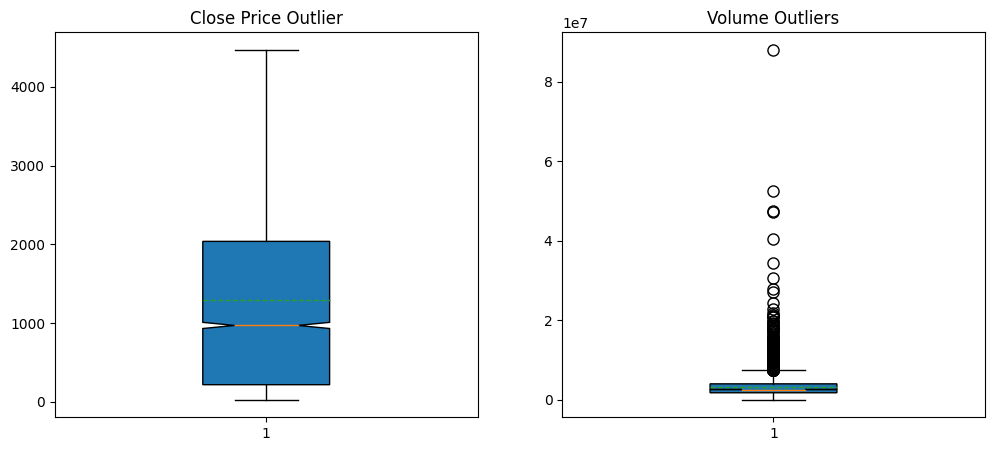

In [16]:
plt.figure(figsize= (12, 5))
plt.subplot(1,2,1)
plt.boxplot(tcs_stock_history_data['Close'], patch_artist=True, notch=True, widths=0.3, meanline=True, showmeans=True,
            flierprops=dict(marker='o', color='red', markersize=8))
plt.title('Close Price Outlier')

plt.subplot(1, 2, 2)
plt.boxplot(tcs_stock_history_data['Volume'], patch_artist=True, notch=True, vert=True, widths=0.3, meanline=True, showmeans=True,
            flierprops=dict(marker='o', color='red', markersize=8))
plt.title('Volume Outliers')
plt.show()

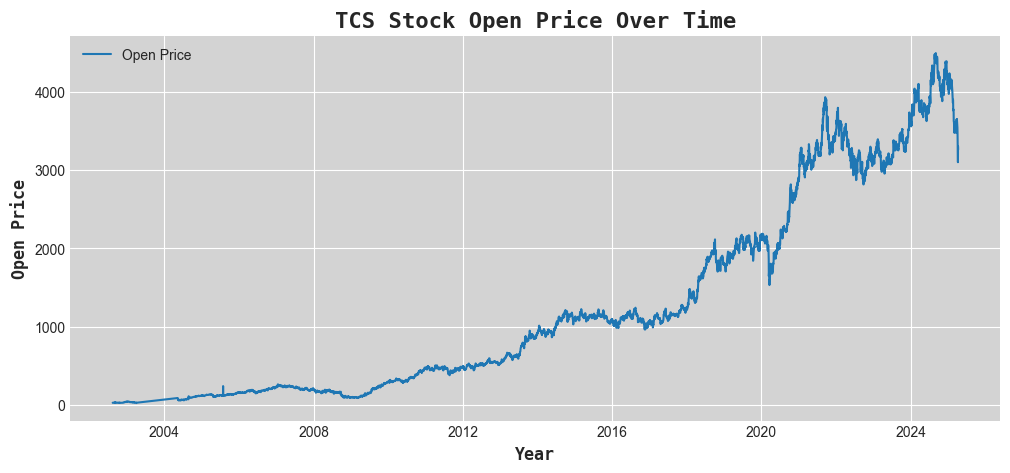

In [17]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Open'], color = '#1f77b4', label = 'Open Price')
plt.xlabel('Year', fontsize=12, fontweight='bold', fontfamily='monospace')
plt.ylabel('Open Price', fontsize=12, fontweight='bold', fontfamily='monospace')
plt.title('TCS Stock Open Price Over Time', fontsize=16, fontweight='bold', fontfamily='monospace')
plt.legend()
plt.show()

In [18]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


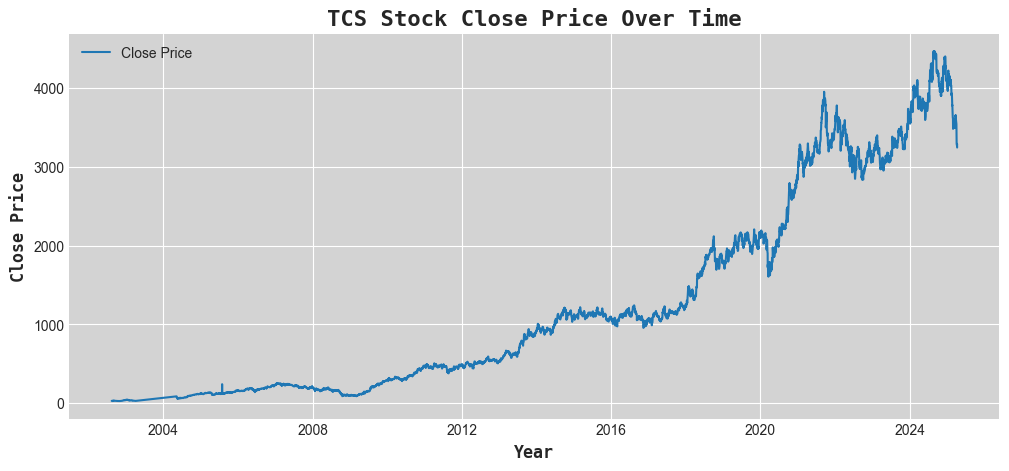

In [19]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Close'], color='#1f77b4', label = 'Close Price')
plt.xlabel('Year', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Close Price', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('TCS Stock Close Price Over Time', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace')
plt.legend()
plt.show()

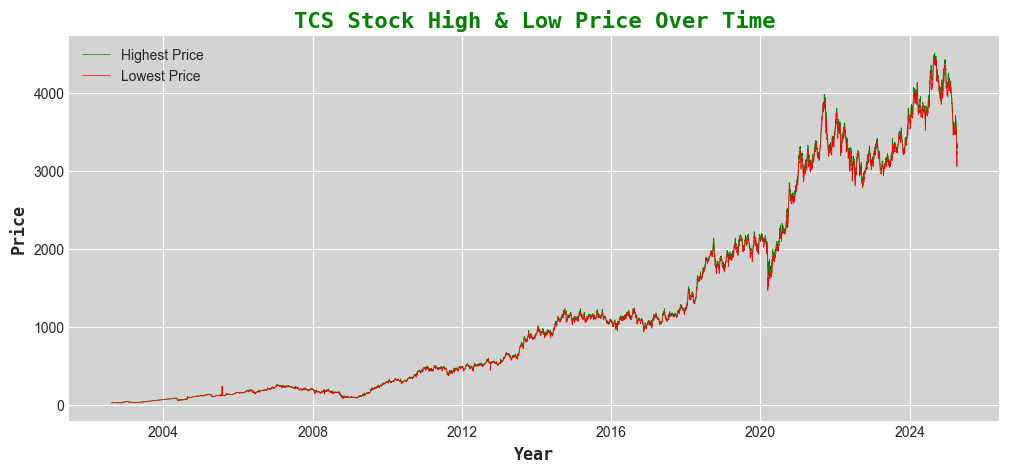

In [20]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['High'], color='green', label = 'Highest Price', linewidth = 0.5)
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Low'], color='red', label = 'Lowest Price', linewidth = 0.5)
plt.xlabel('Year', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Price', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('TCS Stock High & Low Price Over Time', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace', color = 'green')
plt.legend()
plt.show()

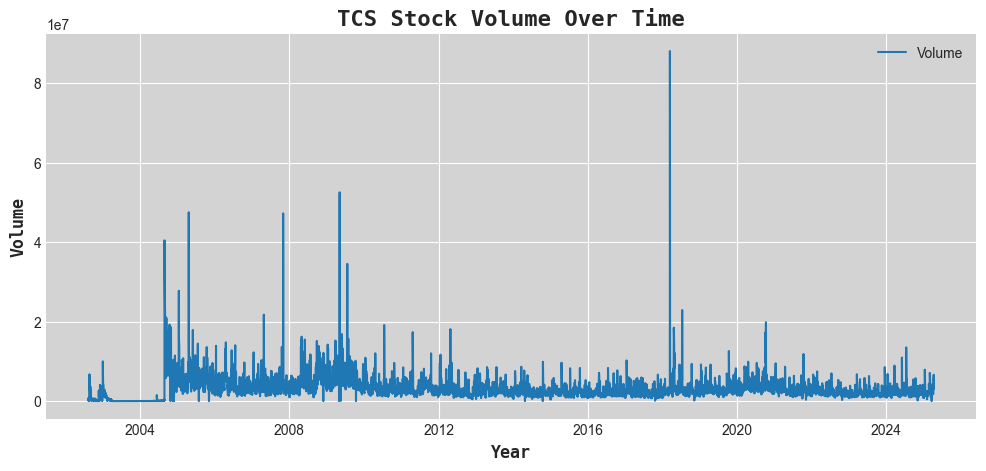

In [21]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize = (12, 5))
plt.gca().set_facecolor('lightgray')
plt.plot(tcs_stock_history_data['Date'], tcs_stock_history_data['Volume'], color='#1f77b4', label = 'Volume')
plt.xlabel('Year', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Volume', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('TCS Stock Volume Over Time', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace')
plt.legend()
plt.show()

In [22]:
years = tcs_stock_history_data['Date'].dt.year
volume_per_year = tcs_stock_history_data.groupby(years)['Volume'].sum()
print(volume_per_year)

Date
2002     109051976
2003      72899672
2004     876093896
2005    1495302344
2006     994139844
2007    1065861528
2008    1296917336
2009    1526527402
2010     840244724
2011     817976452
2012     667246580
2013     674954682
2014     578958206
2015     580144728
2016     539221804
2017     548139150
2018     849403971
2019     735316589
2020     999223368
2021     681162182
2022     581528452
2023     473682090
2024     593722800
2025     178222349
Name: Volume, dtype: int64


In [23]:
fig = px.bar(
    x=volume_per_year.index,
    y=volume_per_year.values,
    text=[f"{volume:,}" for volume in volume_per_year],
    labels={'x': 'Years', 'y': 'Stock Volume'},
    color=volume_per_year.values,
    title="TCS Stock Volume Per Year"
)

fig.update_traces(
    textposition='auto',
    hoverinfo="text+y"
)

fig.update_layout(
    xaxis_title="Years",
    yaxis_title="",
    xaxis_tickangle=-45,
    template="plotly_white"
)
fig.show()

In [24]:
#Checking Stock Split Occurrence
filterd_stock_split = tcs_stock_history_data[tcs_stock_history_data['Stock Splits'] > 0]
filterd_stock_split

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
729,2006-07-28,178.257459,184.865564,175.204656,176.048447,3019608,0.375,2.0
1436,2009-06-16,152.041630,156.087616,147.241995,154.362122,4344006,1.250,2.0
3642,2018-05-31,1625.963422,1649.452732,1618.555607,1632.574219,5049371,14.500,2.0


In [25]:
#Volume Moving averages
volume_moving_average = tcs_stock_history_data['Volume'].rolling(window=100).mean()
pd.DataFrame(volume_moving_average)

,Volume
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
5329,2324690.21
5330,2361383.49
5331,2413558.17
5332,2453257.35


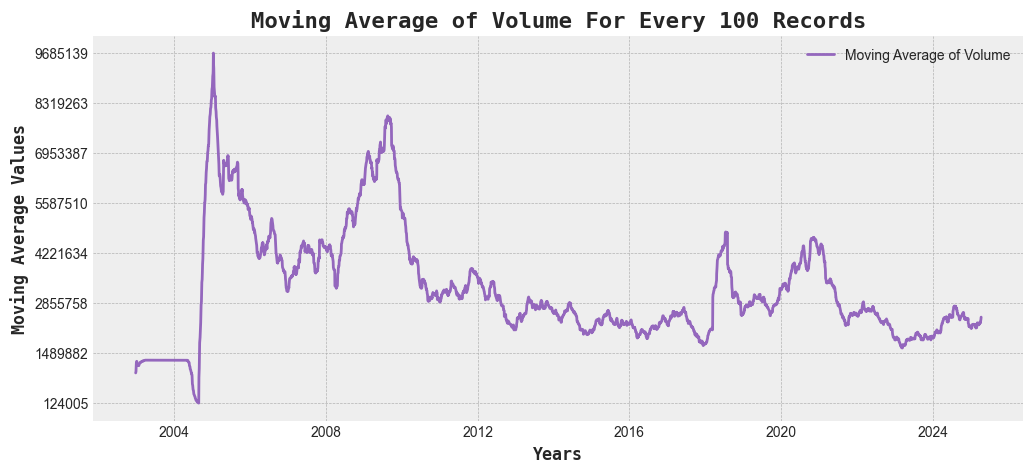

In [26]:
plt.style.use('bmh')
plt.figure(figsize=(12, 5))
plt.plot(tcs_stock_history_data['Date'], volume_moving_average, label = 'Moving Average of Volume', color = '#9467bd')
ytick_values = np.linspace(volume_moving_average.min(), volume_moving_average.max(), num = 8)

plt.xlabel('Years', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.ylabel('Moving Average Values', fontsize = 12, fontweight = 'bold', fontfamily = 'monospace')
plt.title('Moving Average of Volume For Every 100 Records', fontsize = 16, fontweight = 'bold', fontfamily = 'monospace')
plt.yticks(ytick_values)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()

In [27]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [28]:
window_size = 100
MA_Open = tcs_stock_history_data['Open'].rolling(window=window_size).mean()
MA_High = tcs_stock_history_data['High'].rolling(window=window_size).mean()
MA_Low = tcs_stock_history_data['Low'].rolling(window=window_size).mean()
MA_Close = tcs_stock_history_data['Close'].rolling(window=window_size).mean()

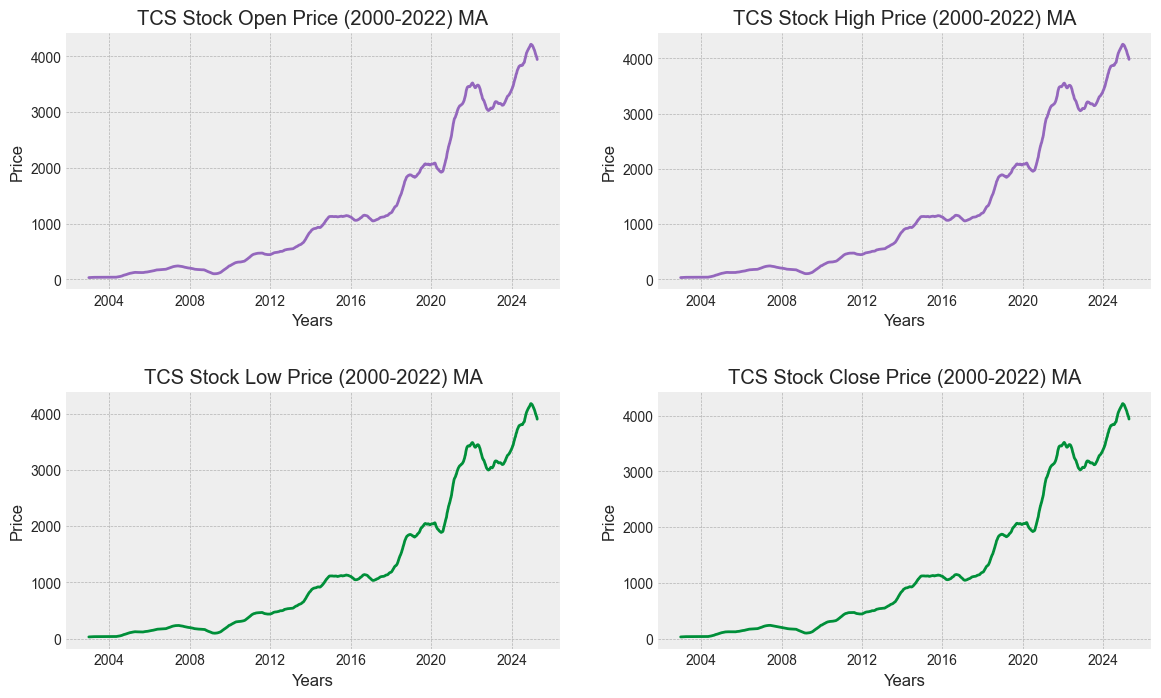

In [29]:
plt.style.use('bmh')
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(tcs_stock_history_data['Date'], MA_Open, color = '#9467bd')
axes[0, 0].set_title("TCS Stock Open Price (2000-2022) MA")
axes[0, 0].set_xlabel("Years")
axes[0, 0].set_ylabel("Price")

axes[0, 1].plot(tcs_stock_history_data['Date'], MA_High, color = '#9467bd')
axes[0, 1].set_title("TCS Stock High Price (2000-2022) MA")
axes[0, 1].set_xlabel("Years")
axes[0, 1].set_ylabel("Price")

axes[1, 0].plot(tcs_stock_history_data['Date'], MA_Low, color = '#008F39')
axes[1, 0].set_title("TCS Stock Low Price (2000-2022) MA")
axes[1, 0].set_xlabel("Years")
axes[1, 0].set_ylabel("Price")

axes[1, 1].plot(tcs_stock_history_data['Date'], MA_Close, color = '#008F39')
axes[1, 1].set_title("TCS Stock Close Price (2000-2022) MA")
axes[1, 1].set_xlabel("Years")
axes[1, 1].set_ylabel("Price")


plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.show()

In [30]:
tcs_stock_history_data["Date"] = pd.to_datetime(tcs_stock_history_data["Date"])
tcs_stock_history_data.set_index("Date", inplace=True)

In [31]:
data = tcs_stock_history_data[["Close"]].values

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [33]:
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

In [34]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [35]:
seq_length = 60  # Use last 60 days to predict the next day
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [36]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [37]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

In [38]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [39]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [40]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
132/132 [==============================] - 11s 47ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 2/50
132/132 [==============================] - 5s 39ms/step - loss: 3.7332e-04 - val_loss: 6.9780e-04
Epoch 3/50
132/132 [==============================] - 5s 40ms/step - loss: 3.0830e-04 - val_loss: 0.0058
Epoch 4/50
132/132 [==============================] - 5s 40ms/step - loss: 2.6399e-04 - val_loss: 9.0350e-04
Epoch 5/50
132/132 [==============================] - 5s 40ms/step - loss: 2.4656e-04 - val_loss: 0.0012
Epoch 6/50
132/132 [==============================] - 5s 40ms/step - loss: 2.2808e-04 - val_loss: 0.0011
Epoch 7/50
132/132 [==============================] - 5s 40ms/step - loss: 2.2105e-04 - val_loss: 7.0988e-04
Epoch 8/50
132/132 [==============================] - 5s 41ms/step - loss: 2.0589e-04 - val_loss: 0.0015
Epoch 9/50
132/132 [==============================] - 5s 40ms/step - loss: 1.9897e-04 - val_loss: 5.2094e-04
Epoch 10/50
132/132 [=====================

In [41]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # Convert back to original scale
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

32/32 [==============================] - 1s 14ms/step


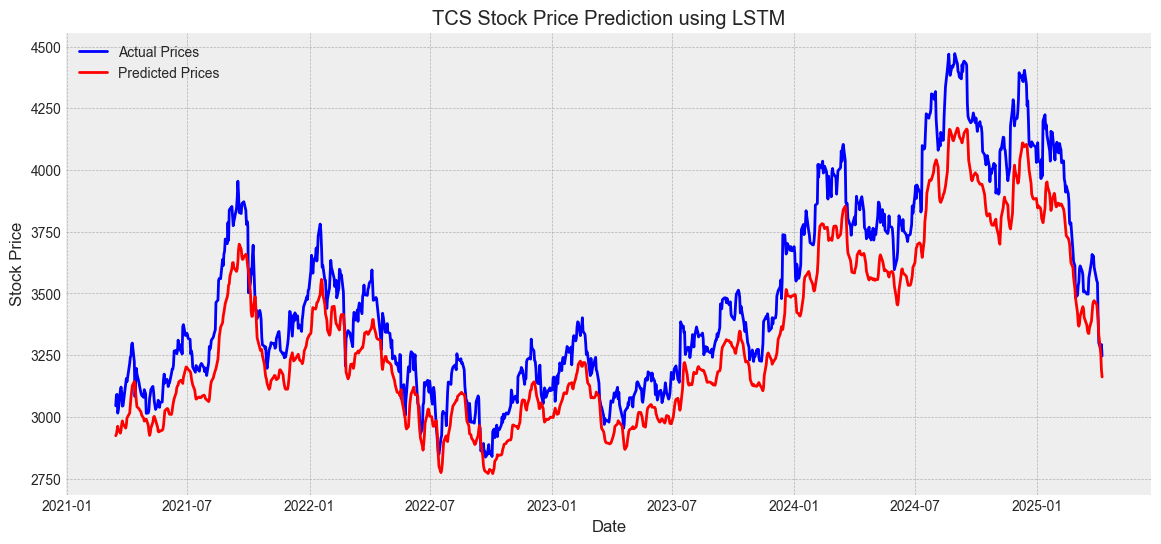

Mean Squared Error: 30841.6907
Mean Absolute Error: 160.1980


In [42]:
plt.figure(figsize=(14, 6))
plt.plot(tcs_stock_history_data.index[train_size + seq_length:], actual, label="Actual Prices", color="blue")
plt.plot(tcs_stock_history_data.index[train_size + seq_length:], predicted, label="Predicted Prices", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("TCS Stock Price Prediction using LSTM")
plt.legend()
plt.show()

# Print model evaluation metrics
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

In [43]:
model.save("tcs_lstm_model.keras")